In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib qt
#%matplotlib widget

In [2]:
import os
import sys
from pathlib import Path

src_dir = str(Path(os.getcwd()).parent / "src")
sys.path.insert(1, src_dir)
#os.environ["PYTHONPATH"] = src_dir

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib.colors import Normalize, ListedColormap
import config
from utils import set_size, print_header
import scienceplots
import pickle
import data_loader
import pandas
from mcs_function import SimulationAttenuation
from mpl_toolkits.axes_grid1 import AxesGrid, ImageGrid
from PIL import Image

plt.style.use('science')

In [4]:
ground_truth_color = "orange"
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [5]:
colors

['#0C5DA5', '#00B945', '#FF9500', '#FF2C00', '#845B97', '#474747', '#9e9e9e']

In [6]:
molecules = ["Hb02", "Hbb", "oxCCO", "redCOO", r"$f_{water}$", r"$f_{fat}$"]

# Background

Absorption spectra

In [7]:
wavelengths=np.linspace(520, 900, 5000)
mu_a_matrix = data_loader.DataLoader.absorption_coefs(
    wavelengths,
    use_diff_oxycco=False,
    use_water_and_fat=True
)

In [ ]:
fig, ax1 = plt.subplots(1, 1, figsize=set_size(443.57848, subplots=(1, 1)), layout='constrained')
handles = []
ax1.plot(wavelengths, mu_a_matrix[:, :4], label=molecules[:4])
ax1.set_xlabel="Wavelengths (nm)"
ax1.set_ylabel("Absorption coefficient $(cm^{-1}mM^{-1}$)")
ax2 = ax1.twinx()
ax2.plot(wavelengths, mu_a_matrix[:, -2], color=colors[4], label=molecules[4])
ax2.plot(wavelengths, mu_a_matrix[:, -1], color=colors[5], label=molecules[5])
ax2.set_ylim(0, 0.1)
ax2.set_ylabel("Absorption $(cm^{-1})$")
fig.legend(loc="upper right", ncols=2, bbox_to_anchor=(0.9, 0.95))
fig.tight_layout()

fig.savefig(config.eval_dir/"chromophore_absorptions.pdf")

# Evaluation

## Simulated

In [30]:
with open(config.simulated_dataset_dir / "simulation_data.pickle", "rb") as f:
    wavelengths, simulation_data = pickle.load(f)

In [31]:
mu_a_matrix = data_loader.DataLoader.absorption_coefs(
    wavelengths,
    use_diff_oxycco=False,
    use_water_and_fat=True
)

Table of baseline concentrations

In [32]:
baseline_table = np.empty((8, 6), dtype=object)

baseline_table[:6, 0] = molecules
baseline_table[-2:, 0] = ["a", "b"]

for tissue_idx, tissue in enumerate(list(simulation_data.keys())):
    baseline_table[:-2, tissue_idx+1] = simulation_data[tissue][0][:, 0]
    baseline_table[-2:, tissue_idx+1] = simulation_data[tissue][1][:, 0]


baseline_table[[0, 1, 4, 5, 7], -1] = 0.15
baseline_table[[2, 3], -1] = 5e-4
baseline_table[6, -1] = 5

np.savetxt(
    config.eval_dir/"simulated/baseline_table.txt",
    baseline_table, fmt="%s",
    comments="",
    delimiter="\t",
    header="\t".join(["parameter"] + list(simulation_data.keys()) + ["sigma"])
)

### Absorption and scattering spectra of simulated tissue

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=set_size(width=443.57848, subplots=(1, 2)))
handles = []
for tissue in list(simulation_data.keys()):
    mu_a = mu_a_matrix @ simulation_data[tissue][0][:, 0]
    a, b = simulation_data[tissue][1][:, 0]
    mu_s_red = a * np.power(wavelengths / 500, -b)
    handles.append(
        ax[0].plot(
            wavelengths,
            mu_a
        )[0]
    )

    ax[1].plot(
        wavelengths,
        mu_s_red
    )



### Attenuation of simulated tissue

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=set_size(width=443.57848))
for tissue in list(simulation_data.keys()):
    ax.plot(
        wavelengths,
        simulation_data[tissue][-1][:, 0],
        label=tissue.capitalize()
    )

ax.set_title("Ground truth tissue attenuation")
ax.set(xlabel='Wavelength (nm)', ylabel='Attenuation')
ax.legend()

fig.savefig(config.eval_dir/"simulated/simulated_attenuations.pdf")

### MCS, Diffusion, Jacques PL comparison

In [ ]:
print_header(config.eval_dir / "simulated/forward/pl_comp_gray matter.dat")

In [ ]:
pl_comp_data_gray_matter = np.loadtxt(config.eval_dir/"simulated/forward/pl_comp_gray matter.dat", skiprows=1)
pl_comp_data_blood_vessel = np.loadtxt(config.eval_dir/"simulated/forward/pl_comp_blood vessel.dat", skiprows=1)
sl_comp_data_gray_matter = np.loadtxt(config.eval_dir/"simulated/forward/sl_comp_gray matter.dat", skiprows=1)
sl_comp_data_blood_vessel = np.loadtxt(config.eval_dir/"simulated/forward/sl_comp_blood vessel.dat", skiprows=1)
pl_comp_data_tumor = np.loadtxt(config.eval_dir/"simulated/forward/pl_comp_tumor.dat", skiprows=1)
sl_comp_data_tumor = np.loadtxt(config.eval_dir/"simulated/forward/sl_comp_tumor.dat", skiprows=1)

In [ ]:
fig, ax = plt.subplots(3, 2, figsize=set_size(width=443.57848, subplots=(3, 2)), layout='constrained')
cur_colors = [colors[5], colors[3]]


for row, (pl_comp_data, sl_comp_data) in enumerate([(pl_comp_data_gray_matter, sl_comp_data_gray_matter), (pl_comp_data_blood_vessel, sl_comp_data_blood_vessel), (pl_comp_data_tumor, sl_comp_data_tumor)]):
    ax[row, 0].plot(
        pl_comp_data[:, 0],
        pl_comp_data[:, 1],
        color=ground_truth_color
    )
    
    ax[row, 1].plot(
        sl_comp_data[:, 0],
        sl_comp_data[:, 1],
        color=ground_truth_color
    )

    for i in [1, 0]:
        ax[row, 0].plot(
            pl_comp_data[:, 0],
            pl_comp_data[:, i+2],
            color=cur_colors[i]
        )

        ax[row, 1].plot(
            sl_comp_data[:, 0],
            sl_comp_data[:, i+2],
            color=cur_colors[i]
        )

    ax[row, 0].set(xlabel="Wavelengths (nm)", ylabel=r"Pathlength/$D_a$ (cm)")
    ax[row, 1].set(xlabel="Wavelengths (nm)", ylabel=r"$D_s$ (cm)")

ax[0, 0].set_title("$D_a$ comparison, gray matter tissue")
ax[0, 1].set_title("$D_s$ comparison, gray matter tissue")
ax[1, 0].set_title("$D_a$ comparison, blood vessel tissue")
ax[1, 1].set_title("$D_s$ comparison, blood vessel tissue")
ax[2, 0].set_title("$D_a$ comparison, tumor tissue")
ax[2, 1].set_title("$D_s$ comparison, tumor tissue")

handles, _ = ax[0, 0].get_legend_handles_labels()
fig.legend(
    handles,
    labels=["Ground truth", "Jacques, specific", "Diffusion"],
    ncols=3,
    loc="outside lower center"
)
fig.savefig(config.eval_dir / "simulated/forward/pl_sl_comparison.pdf")

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=set_size(width=443.57848, subplots=(1, 2)), layout='constrained')
cur_colors = [colors[5], colors[3]]

ax[0].plot(
    pl_comp_data_tumor[:, 0],
    pl_comp_data_tumor[:, 1],
    color=ground_truth_color
)

ax[1].plot(
    sl_comp_data_tumor[:, 0],
    sl_comp_data_tumor[:, 1],
    color=ground_truth_color
)
for i in [1, 0]:
    ax[0].plot(
        pl_comp_data_tumor[:, 0],
        pl_comp_data_tumor[:, i+2],
        color=cur_colors[i]
    )
    ax[1].plot(
        sl_comp_data_tumor[:, 0],
        sl_comp_data_tumor[:, i+2],
        color=cur_colors[i]
    )
ax[0].set(xlabel="Wavelengths (nm)", ylabel=r"Pathlength/$D_a$ (cm)")
ax[1].set(xlabel="Wavelengths (nm)", ylabel=r"$D_s$(cm)")

ax[0].set_title("$D_a$ comparison, tumor tissue")
ax[1].set_title("$D_s$ comparison, tumor tissue")

handles, _ = ax[0].get_legend_handles_labels()
fig.legend(
    handles,
    labels=["Ground truth", "Jacques, specific", "Diffusion"],
    ncols=3,
    loc="outside lower center"
)
fig.savefig(config.eval_dir / "simulated/forward/tumor_pl_sl_comparison.pdf")

### Jacques-m-param analysis

In [ ]:
with open(config.m_params_path, "rb") as f:
    m_params, A_vals, N_vals, dref_vals = pickle.load(f)

In [ ]:
def A_j_jacques(N_vals, m1, m2, m3):
    m1 + m2*np.exp(np.log(N_vals)/m3)

In [ ]:
fig, ax = plt.subplots(4, 1, figsize=set_size(width=443.57848, height=7.4, subplots=(4, 1)))
colors = ["darkblue","darkred", "darkgray", "black"]
assert np.allclose(np.array([len(N_vals[tissue]) for tissue in ["gray matter", "blood vessel"]])-len(N_vals["tumor"]), 0)
num_vals_tissue = len(N_vals['gray matter'])

for i, tissue in enumerate(["gray matter", "blood vessel", "tumor", "general"]):
    N_vals_interp = np.linspace(min(N_vals[tissue]), max(N_vals[tissue]), 100)
    m1, m2, m3 = m_params[tissue]
    # move each axis slightly upwards
    box = ax[i].get_position()
    box.y0 -= 0.03
    box.y1 -= 0.03
    ax[i].set_position(box)
    ax[i].set_xscale("log")
    ax[i].set_title(f"Jacques parameters, {tissue} tissue")
    ax[i].text(
        0.425, 0.6,
        f"m1: {m1:.3}\nm2: {m2:.3}\nm3: {m3:.3}",
        transform=ax[i].transAxes
    )
    label = "$A_j$ using fitted m-parameters" if tissue=="general" else None
    res = ax[i].plot(
        N_vals_interp,
        m1 + m2*np.exp(np.log(N_vals_interp)/m3),
        color=colors[i],
        label=label
    )
    ax[i].set(xlabel="$\mu_s'/\mu_a$", ylabel="$A_j$")
    if tissue == "general":
        lower_idx = 0
        colors2 = ["darkblue", "darkred", "darkgray", "black"]
        for j in range(4):
            label = "Sampled tissue values" if j==3 else None
            res = ax[i].scatter(
                N_vals[tissue][lower_idx:lower_idx+num_vals_tissue],
                A_vals[tissue][lower_idx:lower_idx+num_vals_tissue],
                color=colors2[j],
                label=label
            )
        
            lower_idx += num_vals_tissue
    else:
        ax[i].scatter(
            N_vals[tissue],
            A_vals[tissue],
            color=colors[i]
        )

fig.legend(
    ncols=2,
    loc="outside lower center",
    bbox_to_anchor=[0.5, 0]
)
plt.tight_layout()

fig.savefig(config.eval_dir/"simulated/forward/jacques_params.pdf")


### Forward

In [ ]:
print_header(config.eval_dir / "simulated/forward/gray matter.dat")

In [ ]:
data_gray_matter = np.loadtxt(config.eval_dir / "simulated/forward/gray matter.dat", skiprows=1)
data_artery = np.loadtxt(config.eval_dir / "simulated/forward/artery.dat", skiprows=1)
data_vein = np.loadtxt(config.eval_dir / "simulated/forward/vein.dat", skiprows=1)
data_tumor = np.loadtxt(config.eval_dir / "simulated/forward/tumor.dat", skiprows=1)

In [ ]:
fig, ax = plt.subplots(4, 2, figsize=set_size(width=443.57848, subplots=(4, 2)), layout='constrained')
pparam = dict(xlabel="Wavelength (nm)", ylabel="Attenuation")
lines = np.empty((4, 7), dtype=object)

for row, data in enumerate([data_gray_matter, data_artery, data_vein, data_tumor]):
    # plot ground truth in all subplots
    for col in range(2):
        lines[row, 0] = ax[row, col].plot(
            data[:, 0],
            data[:, 1],
            color=ground_truth_color,
        )[0]
            
    for i, line_idx in enumerate([2, 3]):
        lines[row, i+1] = ax[row, 0].plot(
            data[:, 0],
            data[:, line_idx],
            color=colors[i]
        )[0]
    
    for i, line_idx in enumerate([5, 6, 8, 7]):
        lines[row, i+3] = ax[row, 1].plot(
            data[:, 0],
            data[:, line_idx],
            color=colors[i+2]
        )[0]

for axis in ax.flat:
    axis.set(**pparam)

ax[0, 0].set_title("Linear models, gray matter tissue")
ax[0, 1].set_title("Nonlinear models, gray matter tissue")
ax[1, 0].set_title("Linear models, artery tissue")
ax[1, 1].set_title("Nonlinear models, artery tissue")
ax[2, 0].set_title("Linear models, vein tissue")
ax[2, 1].set_title("Nonlinear models, vein tissue")
ax[3, 0].set_title("Linear models, tumor tissue")
ax[3, 1].set_title("Nonlinear models, tumor tissue")

#fig.subplots_adjust(hspace=0.3, wspace=0.3)
fig.legend(
    handles=list(lines[0, :]), 
    labels=[
        "Ground truth", "MBLL + MC", "MBLL + Diffusion", "Jacques, specific", "Jacques, general",
        "Diffusion", "Inverse MC"
    ],
    loc="outside lower center",
    ncols=4,
    #bbox_to_anchor=(1,-0.1),
    #bbox_transform=fig.transFigure
)
fig.savefig(config.eval_dir / "simulated/forward/simulated_forward.pdf")

### Backward

#### Bar plot

In [ ]:
with open(config.eval_dir/"simulated/backward/model_indices.txt", "r") as f:
    print(f.read())

In [ ]:
with open(config.eval_dir/"simulated/backward/bar_plot_data.pickle", "rb") as f:
    bar_plot_data = pickle.load(f)

In [ ]:
bar_plot_data.shape

Normalize bar-plot-data by GT

In [ ]:
bar_plot_data_normed = bar_plot_data[:, :, :] / bar_plot_data[:, [0], :]

In [ ]:
np.unravel_index(np.argmax(bar_plot_data_normed), bar_plot_data.shape)

In [ ]:
_, num_models, num_moleculs = bar_plot_data_normed.shape

In [ ]:
models = [
    "Ground truth", "MBLL+MC", "MBLL+Diffusion", "MBLL+const. PL", "Diffusion", "Jacques, specific", "Jacques, general",
    "Inverse MC", "Inverse MC, sparse"
]

In [ ]:
len(models)

In [ ]:
molecules = ["Hb02", "Hbb", "oxCCO", "redCOO", r"$f_{fat}$", r"$f_{water}$"]

In [ ]:
#fig, ax = plt.subplots(4, 1, figsize=set_size(width=443.57848, subplots=(4, 1)), layout='constrained')
#x = np.arange(bar_plot_data.shape[1])
#width = 0.125
#
#for tissue_idx, tissue in enumerate(simulation_data.keys()):
#    for molecule_idx, molecule_str in enumerate(molecules):
#        offset = width * molecule_idx
#        rects = ax[tissue_idx].bar(x + offset, bar_plot_data[tissue_idx, :, molecule_idx], width, label=molecule_str)
#        #ax[tissue_idx].bar_label(rects, padding=3)
#
#
#    ax[tissue_idx].set(ylabel="Concentration Percentage to ground truth")
#    ax[tissue_idx].set_title("Reconstructed concentrations for simulated dataset")
#    ax[tissue_idx].set_xticks(x + width, models)
#    ax[tissue_idx].legend(loc="upper left", ncols=1)
#    ax[tissue_idx].set_ylim(0, 10)

In [ ]:
y = np.arange(bar_plot_data_normed.shape[1])
width = 0.125

for fig_idx in range(2):
    fig, ax = plt.subplots(2, 1, figsize=set_size(width=443.57848, subplots=(2, 1)), layout='constrained')

    for tissue_idx, tissue in enumerate(["gray matter", "artery", "vein", "tumor"][2*fig_idx:2*fig_idx+2], start=2*fig_idx):
        ax_idx = tissue_idx - fig_idx*2
        for molecule_idx, molecule_str in enumerate(molecules):
            offset = width * molecule_idx
            rects = ax[ax_idx].barh(y + offset, bar_plot_data_normed[tissue_idx, :, molecule_idx], width, label=molecule_str)
            #ax[tissue_idx].bar_label(rects, padding=3)


        ax[ax_idx].set(xlabel="Concentration percentage to ground truth")
        ax[ax_idx].set_title(f"Reconstructed concentrations, {tissue} tissue")
        ax[ax_idx].set_yticks(y + width, models)
        ax[ax_idx].invert_yaxis()
        ax[ax_idx].legend(loc="lower left", ncols=1)
        ax[ax_idx].set_xlim(-2, 3)

    fig.savefig(config.eval_dir/f"simulated/backward/concentrations_bar_plot{fig_idx}.pdf")

## HELICOID

### Spectrum from data point and literature value

In [9]:
with open(config.simulated_dataset_dir / "simulation_data.pickle", "rb") as f:
    wavelengths, simulation_data = pickle.load(f)

In [10]:
A_mcs = SimulationAttenuation(config.mcs_func_path)

Loaded data with 50000.0 photons and 30 values for mu_s.


In [11]:
loader = data_loader.DataLoaderHELICOID(
    config.dataset_dir,
    520,
    900
)

mu_a_matrix = loader.absorption_coefs(
    use_diff_oxycco=False,
    use_water_and_fat=True
)

A_predicted = A_mcs.A_concentrations(
    loader.wavelengths,
    mu_a_matrix,
    data_loader.DataLoader.tissue_parameters["gray matter"][0],
    *data_loader.DataLoader.tissue_parameters["gray matter"][1]
)[:, 0]

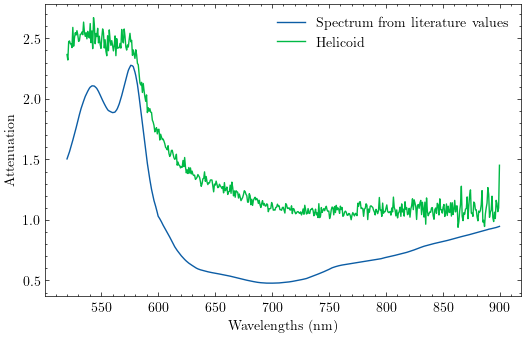

In [13]:
fig, ax = plt.subplots(1, 1, figsize=set_size(443.57848))

ax.plot(
    loader.wavelengths,
    A_predicted,
    label="Spectrum from literature values"
)

# only necessary to set reference pixel
loader.get_attenuation_change("020-01")

ax.plot(
    loader.wavelengths,
    loader.get_attenuation("020-01")[:, *loader.reference_pixel],
    label="Helicoid"
)

ax.legend()
ax.set_xlabel("Wavelengths (nm)")
ax.set_ylabel("Attenuation")

fig.savefig(config.eval_dir/"helicoid/data_example.pdf")

### Absolute vs. Diff plot

In [ ]:
with open(config.eval_dir / "helicoid/concentrations_absolute_diff_average.pickle", "rb") as f:
    bar_plot_data = pickle.load(f)
    # (tissue, models, parameters)

In [ ]:
bar_plot_data.shape

In [ ]:
bar_plot_data_normed = np.nan_to_num(bar_plot_data[:, :, :] / bar_plot_data[:, [0], :])

In [ ]:
models = [
    "Literature values", "Abs.: Jacques", "Diff.: Jacques", "Abs.: NLLS+MCS", "Diff.: NLLS+MCS", "Abs.: MBLL+MCS", "Diff.: MBLL+MCS"  
]

In [ ]:
molecules = ["Hb02", "Hbb", "oxCCO", "redCOO", r"$f_{fat}$", r"$f_{water}$"]

In [ ]:
y = np.arange(bar_plot_data_normed.shape[1])
width = 0.125

fig, ax = plt.subplots(1, 1, figsize=set_size(width=443.57848, subplots=(1, 1)), layout='constrained')

for molecule_idx, molecule_str in enumerate(molecules):
    offset = width * molecule_idx
    rects = ax.barh(y + offset, bar_plot_data_normed[0, :, molecule_idx], width, label=molecule_str)
    #ax[tissue_idx].bar_label(rects, padding=3)


ax.set(xlabel="Concentration percentage to ground truth")
ax.set_title(f"Reconstructed concentrations, {tissue} tissue")
ax.set_yticks(y + width, models)
ax.invert_yaxis()
ax.legend(loc="upper left", ncols=1)
ax.set_xlim(-2, 3)

fig.savefig(config.eval_dir/"helicoid/absolute_diff_bar_plot.pdf")


### Bar plot

In [ ]:
with open(config.eval_dir/"helicoid/bar_plot_data.pickle", "rb") as f:
    bar_plot_data = pickle.load(f)
    # tissue, models, params

Remove difference values from MBLL models

In [ ]:
bar_plot_data = bar_plot_data[:, [0, 3, 4, 5, 6], :]

In [ ]:
bar_plot_data_normed = np.nan_to_num(bar_plot_data[:, :, :] / bar_plot_data[:, [0], :])

In [ ]:
models = [
    "Ground truth", "Jacques, specific", "Jacques, general", "Carp",
    "Inverse MC"
]

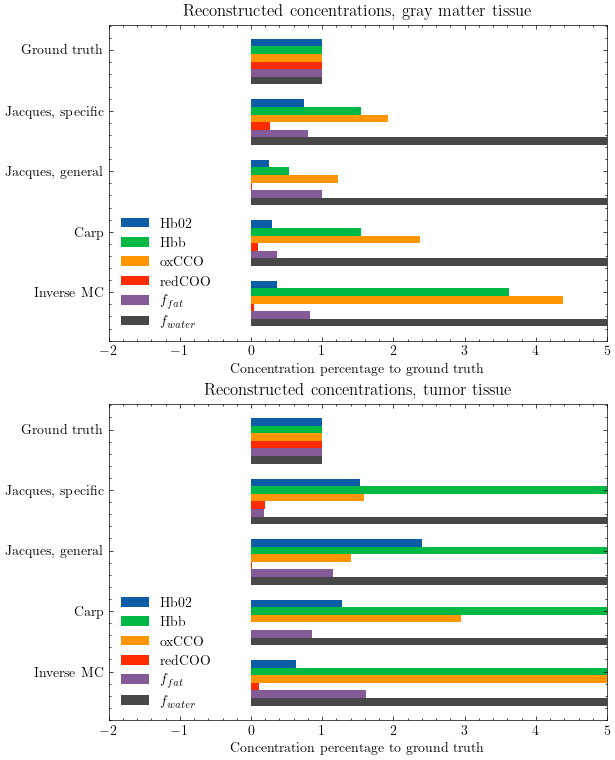

In [106]:
y = np.arange(bar_plot_data_normed.shape[1])
width = 0.125


fig, ax = plt.subplots(2, 1, figsize=set_size(width=443.57848, subplots=(2, 1)), layout='constrained')

for tissue_idx, tissue in enumerate(["gray matter", "tumor"]):
    for molecule_idx, molecule_str in enumerate(molecules):
        offset = width * molecule_idx
        rects = ax[tissue_idx].barh(y + offset, bar_plot_data_normed[tissue_idx, :, molecule_idx], width, label=molecule_str)
        #ax[tissue_idx].bar_label(rects, padding=3)


    ax[tissue_idx].set(xlabel="Concentration percentage to ground truth")
    ax[tissue_idx].set_title(f"Reconstructed concentrations, {tissue} tissue")
    ax[tissue_idx].set_yticks(y + width, models)
    ax[tissue_idx].invert_yaxis()
    ax[tissue_idx].legend(loc="lower left", ncols=1)
    ax[tissue_idx].set_xlim(-2, 5)

fig.savefig(config.eval_dir/f"helicoid/bar_plot0.pdf")

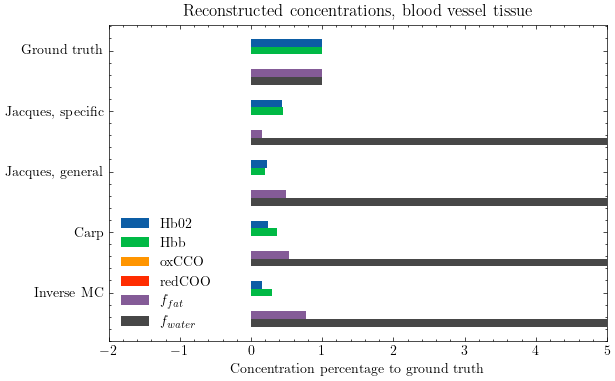

In [107]:
y = np.arange(bar_plot_data_normed.shape[1])
width = 0.125


fig, ax = plt.subplots(1, 1, figsize=set_size(width=443.57848, subplots=(1, 1)), layout='constrained')

for molecule_idx, molecule_str in enumerate(molecules):
    offset = width * molecule_idx
    rects = ax.barh(y + offset, bar_plot_data_normed[2, :, molecule_idx], width, label=molecule_str)
    #ax[tissue_idx].bar_label(rects, padding=3)


ax.set(xlabel="Concentration percentage to ground truth")
ax.set_title(f"Reconstructed concentrations, blood vessel tissue")
ax.set_yticks(y + width, models)
ax.invert_yaxis()
ax.legend(loc="lower left", ncols=1)
ax.set_xlim(-2, 5)

fig.savefig(config.eval_dir/f"helicoid/bar_plot1.pdf")

### Reconstruction times

In [112]:
with open(config.eval_dir/"helicoid/times_df.pickle", "rb") as f:
    df = pickle.load(f)

In [113]:
df

,Runtime [s]
MBLL MCS,0.220542
MBLL Carp,0.214777
"Jacques, specific",68.468879
"Jacques, general",50.245157
Carp,70.900727
NLLS + MCS,9492.682005
"MBLL, const. GM PL",0.000000
MBLL ones PL,0.000000


In [118]:
avg_reconstruction_times = np.empty(4)
avg_reconstruction_times[0] = np.average(df.values[0:2, 0])
avg_reconstruction_times[1] = np.average(df.values[2:4, 0])
avg_reconstruction_times[2:4] = df.values[4:6, 0]

In [123]:
df2 = pandas.DataFrame(avg_reconstruction_times)
df2.index = ["MBLL", "Jacques", "Diffusion", "Inverse MC"]
df2.columns = ["Reconstruction time [s]"]

In [124]:
df2.to_csv(
    config.eval_dir/"helicoid/times.txt",
    sep="\t",
    index_label="Models",
)

### Images

In [7]:
loader = data_loader.DataLoaderHELICOID(
    config.dataset_dir,
    400, 1000
)
loader.load_data("020-01")
print(loader.label_map.shape)

/home/leon/anaconda3/envs/nonlinear-fit/lib/python3.11/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


(378, 330)


RGB Image from Helicoid, second one with labels and reference pixels.

In [8]:
config.dataset_dir

PosixPath('/media/leon/T7/IDP/dataset/HELICoiD/HSI_Human_Brain_Database_IEEE_Access')

#### Helicoid sample image

In [9]:
bv_pixels = np.nonzero(loader.label_map == 3)
first_bv_pixel = list(zip(*bv_pixels))[0]

In [10]:
rgb_img = Image.open(config.dataset_dir/"020-01/image.jpg")
rgb_img.size

(330, 378)

In [11]:
rgb_wavelengths = np.array([708.97, 539.44, 479.06])
rgb_idxs = np.argmin(np.abs(loader.wavelengths[:, None] - rgb_wavelengths[None, :]), axis=0)
img_data_reflectance = loader.reflectance[rgb_idxs, :, :]
img_data_reflectance.transpose(1, 2, 0).shape

(378, 330, 3)

**Note:**
- image has a width of 330, and height of 378 pixels
- Loader (i.e. spectral library) reads image and label map into array of size (height, width)
- imshow also expects image matrix to be in shape (height, width) but prints
- when you take an idx from the np.array, i.e. via list(zip(*np.nonzero(loader.label_map == 1)))[0], then you get (row, width)
- but width is plotted along x-axis, and row along y-axis, therefore you have to switch them when plotting over imshow image with ax.plot()

In [ ]:
label_mask = np.ma.masked_where(loader.label_map.astype(int) == 0, loader.label_map.astype(int))
cmap = ListedColormap(["green", "orange", "red", "white"])

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


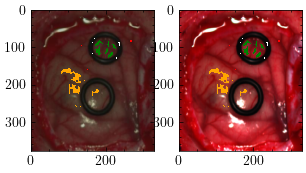

In [198]:
fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.imshow(rgb_img)
ax2.imshow(img_data_reflectance.transpose(1, 2, 0))
ax1.imshow(label_mask, cmap=cmap)
ax2.imshow(label_mask, cmap=cmap)

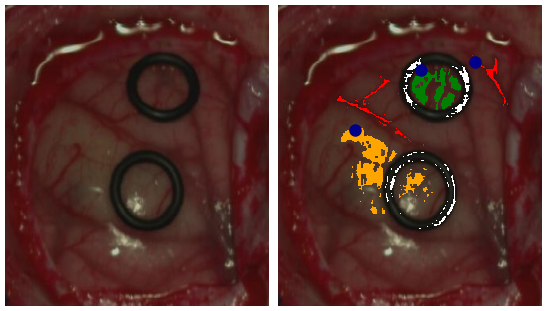

In [226]:
fig = plt.figure(figsize=set_size(width=500))
grid = AxesGrid(
    fig,
    (1, 1, 1),
    nrows_ncols=(1,2),
    axes_pad=0.1,
)

grid[0].imshow(rgb_img)
grid[1].imshow(rgb_img)
grid[1].imshow(label_mask, cmap=cmap)
grid[0].set_axis_off()
grid[1].set_axis_off()

for tissue_idx, tissue in enumerate(["gray matter", "tumor", "blood vessel"], start=1):
    ref_pixel_row, ref_pixel_col = list(zip(*np.nonzero(loader.label_map == tissue_idx)))[loader.reference_pixel_tissue_ctr]
    grid[1].plot(
        ref_pixel_col,
        ref_pixel_row,
        marker="o",
        markersize="8",
        color="darkblue",

    )

fig.savefig(config.eval_dir/"helicoid/image.pdf")

#### Concentration Images

In [29]:
patient_id = "020-01"

In [30]:
loader = data_loader.DataLoaderHELICOID(
    config.dataset_dir,
    520, 900
)
loader.load_data("020-01")
print(loader.label_map.shape)

/home/leon/anaconda3/envs/nonlinear-fit/lib/python3.11/site-packages/spectral/io/envi.py:175: UserWarning: Parameters with non-lowercase names encountered and converted to lowercase. To retain source file parameter name capitalization, set spectral.settings.envi_support_nonlowercase_params to True.
  warnings.warn(msg)


(378, 330)


In [31]:
with open(config.eval_dir/f"helicoid/reconstructed_concentrations_full_image_{patient_id}.pickle", "rb") as f:
    img_data_flat = pickle.load(f)

swap tissue-independent MBLL models with Diffusion and Inverse MC

In [15]:
img_data_flat2 = img_data_flat.copy()
img_data_flat2[2:4, :, :] = img_data_flat[6:8, :, :]
img_data_flat2[4:8, :, :] = img_data_flat[2:6, :, :]

In [16]:
np.nan_to_num(img_data_flat2[-1, 5, :]).max()

0.9999999999999999

Reshape

In [17]:
img_data = img_data_flat2[:, :6, :].reshape((img_data_flat2.shape[0], 6) + loader.label_map.shape)
img_data.shape # models, params, spectrum

(8, 6, 378, 330)

- colorbar für molekül über jeder Spalte
- ylabel = model name für jede Reihe

In [18]:
models = ["MBLL+MC", "MBLL+Diffusion", "MBLL+const. GM PL", "MBLL+const. PL", "Jacques, specific", "Jacques, general", "Diffusion", "NLLS+MC"]

In [19]:
img_size = 2000

In [20]:
%matplotlib qt

First only the MBLL images, without any modifications.

In [21]:
img_data_mbll = img_data[:4, :, :, :].copy()

In [ ]:
fig = plt.figure(figsize=set_size(width=img_size/2))
norms = []

grid = AxesGrid(
    fig,
    (1, 1, 1),
    nrows_ncols=(img_data_mbll.shape[:2]),
    axes_pad=0.1,
    cbar_mode="edge",
    cbar_location="top",
    cbar_size="15%",
)

for img_idx in range(np.prod(img_data_mbll.shape[:2])):
    model_idx = img_idx // img_data_mbll.shape[1]
    mol_idx = img_idx % img_data_mbll.shape[1]

    if model_idx == 0:
        norms.append(Normalize(vmin=np.nanmin(img_data_mbll[:, mol_idx, :]), vmax=np.nanmax(img_data_mbll[:, mol_idx, :])))

    img = grid[img_idx].imshow(img_data_mbll[model_idx, mol_idx, :, :], norm=norms[mol_idx], cmap="magma")
    grid[img_idx].set_yticks([])
    grid[img_idx].set_xticks([])

    if mol_idx == 0:
        grid[img_idx].set_ylabel(models[model_idx])

    if model_idx == 0:
        grid.cbar_axes[mol_idx].colorbar(img)
        grid.cbar_axes[mol_idx].set_title(molecules[mol_idx])
        grid.cbar_axes[mol_idx].xaxis.set_ticks_position("top")

fig.savefig(config.eval_dir/f"helicoid/concentration_images_mbll_original_{patient_id}.pdf")

Now only the NLLS images.

In [23]:
img_data_nlls = img_data[4:, :, :, :].copy()

In [ ]:
fig = plt.figure(figsize=set_size(width=img_size/2))
norms = []

grid = AxesGrid(
    fig,
    (1, 1, 1),
    nrows_ncols=(img_data_nlls.shape[:2]),
    axes_pad=0.1,
    cbar_mode="edge",
    cbar_location="top",
    cbar_size="15%",
)

for img_idx in range(np.prod(img_data_nlls.shape[:2])):
    model_idx = img_idx // img_data_nlls.shape[1]
    mol_idx = img_idx % img_data_nlls.shape[1]

    if model_idx == 0:
        norms.append(Normalize(vmin=np.nanmin(img_data_nlls[:, mol_idx, :, :]), vmax=np.nanmax(img_data_nlls[:, mol_idx, :, :])))

    img = grid[img_idx].imshow(img_data_nlls[model_idx, mol_idx, :, :], norm=norms[mol_idx], cmap="magma")
    grid[img_idx].set_yticks([])
    grid[img_idx].set_xticks([])

    if mol_idx == 0:
        grid[img_idx].set_ylabel(models[4 + model_idx])

    if model_idx == 0:
        grid.cbar_axes[mol_idx].colorbar(img)
        grid.cbar_axes[mol_idx].set_title(molecules[mol_idx])
        grid.cbar_axes[mol_idx].xaxis.set_ticks_position("top")

fig.savefig(config.eval_dir/f"helicoid/concentration_images_nlls_{patient_id}.pdf")

Now every model. To make MBLL models comparable with absolute values of NLLS models, we add literature values (per tissue) to MBLL image data.

In [25]:
for tissue_idx, tissue in enumerate(["unlabeled", "gray matter", "tumor", "blood vessel"]):
    tissue_key = tissue if tissue != "unlabeled" else "gray matter"
    img_data[:2, :, (loader.label_map == tissue_idx)] += data_loader.DataLoader.tissue_parameters[tissue_key][0][None, :, None]

img_data[2:4, :, (loader.label_map != 4)] += data_loader.DataLoader.tissue_parameters["gray matter"][0][None, :, None]

This code does steps above, but removes MBLL const, for better visualization:

In [26]:
remove_mbll = False
if remove_mbll:
    ### without MBLL const PL
    img_data_flat2 = np.empty((img_data_flat.shape[0]-1, img_data_flat.shape[1], img_data_flat.shape[2]))
    img_data_flat2[:2, :, :] = img_data_flat[:2, :, :]
    img_data_flat2[2, :, :] = img_data_flat[6, :, :]
    img_data_flat2[3:7, :, :] = img_data_flat[2:6, :, :] 
    img_data = img_data_flat2[:, :6, :].reshape((img_data_flat2.shape[0], 6) + loader.label_map.shape)
    img_data.shape # models, params, spectrum
    for tissue_idx, tissue in enumerate(["unlabeled", "gray matter", "tumor", "blood vessel"]):
        tissue_key = tissue if tissue != "unlabeled" else "gray matter"
        img_data[:2, :, (loader.label_map == tissue_idx)] += data_loader.DataLoader.tissue_parameters[tissue_key][0][None, :, None]

    img_data[2, :, (loader.label_map != 4)] += data_loader.DataLoader.tissue_parameters["gray matter"][0][None, :]
    models = ["MBLL+MC", "MBLL+Diffusion", "MBLL+const. GM PL", "Jacques, specific", "Jacques, general", "Diffusion", "NLLS+MC"]
else:
    print("Skipped.")

Skipped.


In [ ]:
fig = plt.figure(figsize=(set_size(img_size)))
#norm = Normalize(vmin=np.min(img_data), vmax=np.max(img_data))
norms = []

grid = AxesGrid(
    fig,
    (1, 1, 1),
    nrows_ncols=(img_data.shape[:2]),
    axes_pad=0.1,
    cbar_mode="edge",
    cbar_location="top",
    cbar_size="15%",
)

for img_idx in range(np.prod(img_data.shape[:2])):
    model_idx = img_idx // img_data.shape[1]
    mol_idx = img_idx % img_data.shape[1]

    if model_idx == 0:
        norms.append(Normalize(vmin=np.nanmin(img_data[:, mol_idx, :, :]), vmax=np.nanmax(img_data[:, mol_idx, :, :])))

    img = grid[img_idx].imshow(img_data[model_idx, mol_idx, :, :], norm=norms[mol_idx], cmap="magma")
    grid[img_idx].set_yticks([])
    grid[img_idx].set_xticks([])

    if mol_idx == 0:
        grid[img_idx].set_ylabel(models[model_idx])

    if model_idx == 0:
        grid.cbar_axes[mol_idx].colorbar(img)
        grid.cbar_axes[mol_idx].set_title(molecules[mol_idx])
        grid.cbar_axes[mol_idx].xaxis.set_ticks_position("top")
        

fig.savefig(config.eval_dir/f"helicoid/concentration_images_shared_cbar_{patient_id}.pdf")

**Only for display on PC, for analysis.** Same as above, but transposed for larger screen.

In [ ]:
fig = plt.figure(figsize=(100, 50))

norms = []

grid = AxesGrid(
    fig,
    (1, 1, 1),
    nrows_ncols=(img_data.shape[1], img_data.shape[0]),
    axes_pad=0.1,
    cbar_mode="edge",
    cbar_location="right",
    cbar_size="15%",
)

for img_idx in range(np.prod(img_data.shape[:2])):
    model_idx = img_idx % img_data.shape[0]
    mol_idx = img_idx // img_data.shape[0]

    if model_idx == 0:
        norms.append(Normalize(vmin=np.nanmin(img_data[:, mol_idx, :, :]), vmax=np.nanmax(img_data[:, mol_idx, :, :])))
    
    img = grid[img_idx].imshow(img_data[model_idx, mol_idx, :, :], norm=norms[mol_idx], cmap="magma")
    grid[img_idx].set_yticks([])
    grid[img_idx].set_xticks([])

    if model_idx == 0:
        grid[img_idx].set_ylabel(molecules[mol_idx])
        grid.cbar_axes[mol_idx].colorbar(img)

    if mol_idx == 0:
        grid[img_idx].set_title(models[model_idx])

Now MBLL and NLLS data together, but using two colormaps. We use MBLL data with added literature values, to report absolute concentrations for both tissues.

In [ ]:
fig = plt.figure(figsize=(100, 50))

num_mbll_models = 4

for i, cur_img_data in enumerate(np.split(img_data, np.array([num_mbll_models]), axis=0)):
    norms = []
    num_models, num_mols = cur_img_data.shape[:2]
    grid = AxesGrid(
        fig,
        (2, 1, i+1),
        nrows_ncols=(num_models, num_mols),
        axes_pad=0.1,
        cbar_mode="edge",
        cbar_location="top",
        cbar_size="15%"
    )

    for img_idx in range(num_models*num_mols):
        model_idx = img_idx // num_mols
        mol_idx = img_idx % num_mols

        if model_idx == 0:
            norms.append(Normalize(vmin=np.nanmin(cur_img_data[:, mol_idx, :, :]), vmax=np.nanmax(cur_img_data[:, mol_idx, :, :])))
        
        img = grid[img_idx].imshow(cur_img_data[model_idx, mol_idx, :, :], norm=norms[mol_idx], cmap="magma")
        grid[img_idx].set_yticks([])
        grid[img_idx].set_xticks([])

        if model_idx == 0:
            grid.cbar_axes[mol_idx].colorbar(img)
            grid.cbar_axes[mol_idx].set_title(molecules[mol_idx])
            grid.cbar_axes[mol_idx].xaxis.set_ticks_position("top")
        
        if mol_idx == 0:
            grid[img_idx].set_ylabel(models[num_mbll_models*i + model_idx])

fig.savefig(config.eval_dir/f"helicoid/concentration_images_seperate_cbar_{patient_id}.pdf")

### Prediction error

In [ ]:
with open(config.eval_dir/"helicoid/prediction_error_df.pickle", "rb") as f:
    df = pickle.load(f)

In [10]:
df

,GM,tumor,blood vessel,avg
MBLL MCS,1.308245e-17,3.704404e-17,1.018056e-15,6.894058e-16
MBLL Carp,7.127102e-17,7.755285e-17,5.709218e-16,4.067315e-16
"Jacques, specific",5.500918e-01,8.068108e-01,1.176531e+00,9.239149e-01
"Jacques, general",4.721563e-01,4.713298e-01,1.532275e+00,1.004520e+00
Carp,6.810452e-01,3.994714e-01,1.462624e+00,1.008821e+00
NLLS + MCS,5.463555e-01,5.682353e-01,1.621428e+00,1.091462e+00


In [11]:
df2 = pandas.DataFrame(df.values[2:, :])
df2.index = ["Jacques, specific", "Jacques, general", "Diffusion", "Inverse MC"]
df2.columns = ["Gray matter", "Tumor", "Blood vessel", "Average"]

In [12]:
df2.to_csv(
    config.eval_dir/"helicoid/prediction_error.txt",
    sep="\t",
    index_label="Models"
)